# Covid-19 Tracker

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn.linear_model as sklm
import sklearn.covariance as skc

import requests
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('darkgrid')


Bad key "text.kerning_factor" on line 4 in
/Users/sonukumar/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Installation for interactive plots
Plotly is a library that allows us to create interactive plots for better visualization.

In order for this all to work, you'll need to install plotly and cufflinks to call plots directly off of a pandas dataframe. These libraries are not currently available through **conda** but are available through **pip**. Install the libraries at your command line/terminal using:

    pip install plotly
    pip install cufflinks

** NOTE: Make sure you only have one installation of Python on your computer when you do this, otherwise the installation may not work. **

## Imports and Set-up

In [2]:
interactive = True
try:
    from plotly import __version__
    from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

    import cufflinks as cf
    init_notebook_mode(connected=True)
    cf.go_offline()

    if (__version__[0] >= '1') and cf:
        print('Requirements satisfied!')
    else:
        interactive = False
    
    def configure_plotly_browser_state():
        import IPython
        display(IPython.core.display.HTML('''
                <script src="/static/components/requirejs/require.js"></script>
                <script>
                requirejs.config({
                    paths: {
                    base: '/static/base',
                    plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
                    },
                });
                </script>
                '''))
    import IPython
    IPython.get_ipython().events.register('pre_run_cell', configure_plotly_browser_state)
except:
    interactive = False
    print('Please install plotly and cufflinks and run again!!!')
    print('Or you can continue with simple plots...')

Requirements satisfied!


In [3]:
interactive = False

## Loading Data and Preprocessing

In [4]:
def fetch_data(country):
    """
    Return the data for `country` as a dataframe
    """
    response = requests.get(f'https://api.covid19api.com/total/dayone/country/{country}', timeout=5)
    if response.status_code == 200:
        json = response.text
        df = pd.read_json(json)
        df.set_index('Date', inplace=True)
        df.index.name = None
        return df[['Active', 'Recovered', 'Deaths', 'Confirmed']]
    else:
        raise requests.RequestException(f'Error code: {response.status_code}')

To find the name for a country, go to https://api.covid19api.com/countries, find your country, and copy the `Slug`.

In [5]:
# Covid-19 data of India
df = fetch_data('india')
df.head()

,Active,Recovered,Deaths,Confirmed
2020-01-30 00:00:00+00:00,1,0,0,1
2020-01-31 00:00:00+00:00,1,0,0,1
2020-02-01 00:00:00+00:00,1,0,0,1
2020-02-02 00:00:00+00:00,2,0,0,2
2020-02-03 00:00:00+00:00,3,0,0,3


In [6]:
cols = df.columns
print(cols)
df.tail()

Index(['Active', 'Recovered', 'Deaths', 'Confirmed'], dtype='object')


,Active,Recovered,Deaths,Confirmed
2020-08-30 00:00:00+00:00,781975,2774801,64469,3621245
2020-08-31 00:00:00+00:00,785996,2839882,65288,3691166
2020-09-01 00:00:00+00:00,801282,2901908,66333,3769523
2020-09-02 00:00:00+00:00,815538,2970492,67376,3853406
2020-09-03 00:00:00+00:00,831124,3037151,68472,3936747


## See the trend in data

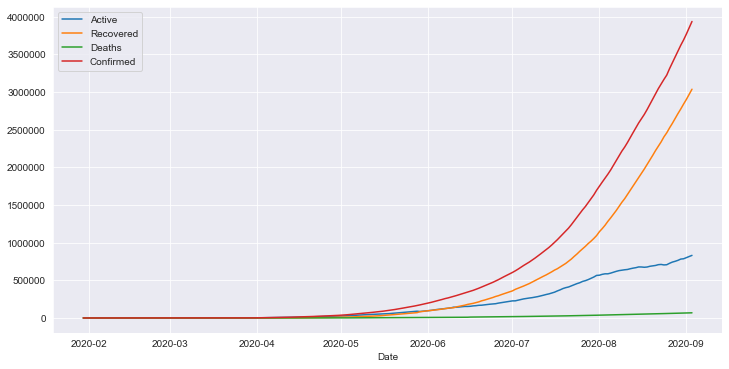

In [7]:
if interactive:
    df.iplot(kind='spread')
else:
    for c in cols:
        plt.plot(df[c], label=c)
    plt.legend()
    plt.xlabel('Date')

In [8]:
# Covid-19 data of Andorra
df_andorra = fetch_data('andorra')
df_andorra.tail()

,Active,Recovered,Deaths,Confirmed
2020-08-30 00:00:00+00:00,169,902,53,1124
2020-08-31 00:00:00+00:00,215,908,53,1176
2020-09-01 00:00:00+00:00,223,908,53,1184
2020-09-02 00:00:00+00:00,237,909,53,1199
2020-09-03 00:00:00+00:00,237,909,53,1199


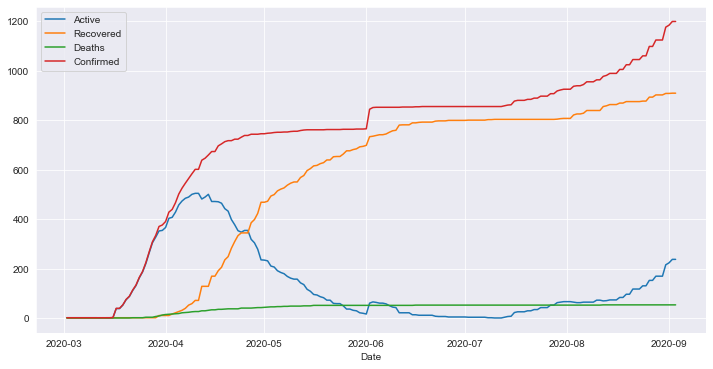

In [9]:
if interactive:
    df_andorra.iplot(kind='spread')
else:
    for c in cols:
        plt.plot(df_andorra[c], label=c)
    plt.legend()
    plt.xlabel('Date')

Comparing the graphs, it is apparent that the infection follows the above model. The equation for infection is (from https://www.researchgate.net/publication/308744463_An_Algebraic_Solution_for_the_Kermack-McKendrick_Model)

\begin{equation*}
I(\tau) = \frac{\omega}{R_0} - S(0)e^{\omega-R_0}
\end{equation*}

This shows that we can use exponential regression (linear regression thereby) to predict the number of cases for atleast a day in future.

### The other observation

Let's see how the number of recovery and active cases are related. Nothing is apparent from the graph above, instead we'll check for the differences.

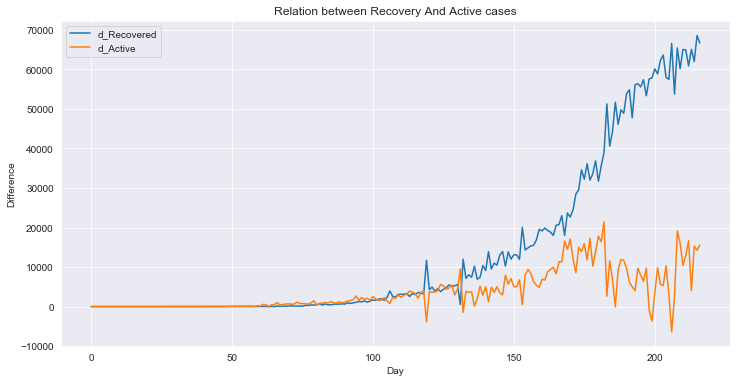

In [10]:
d_recov = np.diff(df['Recovered'])
d_activ = np.diff(df['Active'])

if interactive:
    df_diff = pd.DataFrame()
    df_diff['d_Recovered'] = d_recov
    df_diff['d_Active'] = d_activ
    df_diff.iplot(title='Relation between Recovery And Active cases', xTitle='Days', yTitle='Difference')
else:
    plt.plot(d_recov, label='d_Recovered')
    plt.plot(d_activ, label='d_Active')
    plt.legend()
    plt.xlabel('Day')
    plt.ylabel('Difference')
    plt.title('Relation between Recovery And Active cases')

Although nothing is apparent still, we can see that if one goes up, the other goes down. This is understandable since the number of active cases will decrease if more people recover. We'll check for another difference.

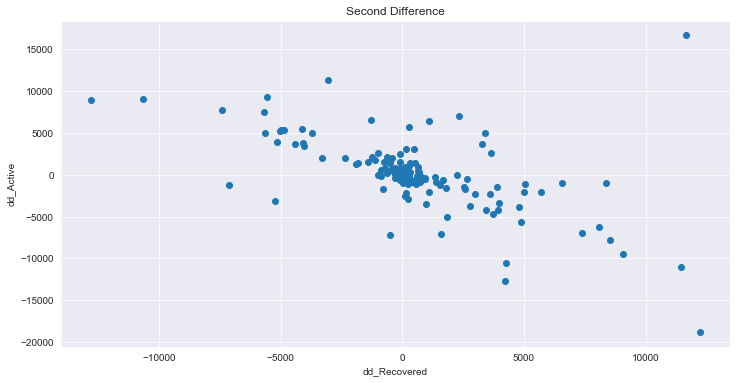

In [11]:
dd_recov = np.diff(d_recov)
dd_activ = np.diff(d_activ)

if interactive:
    df_d_diff = pd.DataFrame()
    df_d_diff['dd_Recovered'] = dd_recov
    df_d_diff['dd_Active'] = dd_activ
    df_d_diff.iplot(kind='scatter', x='dd_Recovered', y='dd_Active', mode='markers',
                    title='Second Difference', colors='red',
                    xTitle='dd_Recovered', size=8,
                    yTitle='dd_Active')
else:
    plt.scatter(dd_recov, dd_activ)
    plt.xlabel('dd_Recovered')
    plt.ylabel('dd_Active')
    plt.title('Second Difference')

This graph shows a clear linear relation between the two, as expected. We'll use this info to get one of the values from the other. Also, if $x$ and $y$ are exponentially related, than either $e^x$ and $y$, or $x$ and $\log y$ will be linearly related. We'll use the second option since it allows to keep the numbers small.

Moreover, in the dataset, `Confirmed = Active + Recovered + Deaths`.

We've the process necessary for making predictions. As an additional step we'll use a moving window for making successive prediction since the trend in data is supposed to change (like, active cases first increases, then decreases).

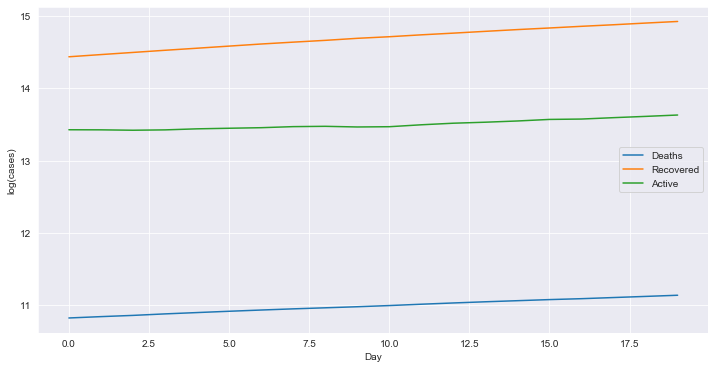

In [12]:
window_size = 20
last_df = df[-window_size:]
# last_df = df[-25:-5]


x = np.array([last_df.index.dayofyear]).T
x -= x.min()
yd, yr, ya = np.array(last_df['Deaths']), np.array(last_df['Recovered']), np.array(last_df['Active'])
lyd, lyr, lya = np.log((yd, yr, ya))  # transform coordinate

if interactive:
    temp = pd.DataFrame()
    temp['Deaths'] = lyd
    temp['Recovered'] = lyr
    temp['Active'] = lya
    temp.iplot(title='Data Trends', xTitle='Days', yTitle='log(cases)')
else:
    plt.plot(x.T[0], lyd, label='Deaths')
    plt.plot(x.T[0], lyr, label='Recovered')
    plt.plot(x.T[0], lya, label='Active')
    plt.legend()
    plt.xlabel('Day')
    plt.ylabel('log(cases)')

# Model Building

### The Kermack-McKendrick Model of Infectious Disease

https://mathworld.wolfram.com/Kermack-McKendrickModel.html

https://github.com/sherlockdoyle/Python-Codes/blob/master/notebooks/nCoV-SIRD.ipynb

The SIR model is one of the simplest compartmental models, and many models are derivatives of this basic form. The model consists of three compartments:

 * **S**usceptible: People still not infected but can get infected.
 
 * **I**nfectious: People currently infected.
 
 * **R**ecovered/**R**emoved: People once infected, currently cured, can get infected again.
 
 * **D**ismissed/**D**ead/**D**eceased: People once infected, won't get infected again, either cause they're dead or are immune now.
 
 <img src="sird.png">


*Infected* in this graph is *Active* in the other graphs. *Dismissed* in this graph is *Recovered* in the other graphs.

# Implenatation of above model

In [13]:
y = np.array([lyd, lyr]).T
model = sklm.LinearRegression()
model.fit(x, y)
print('R2 score:', model.score(x, y))
print('RMSE error:', np.sqrt(((model.predict(x)-y)**2).mean()))

px = x[-1, 0] + 1
pyd, pyr = np.round(np.exp(model.predict([[px]]))).astype(int)[0]

R2 score: 0.9977570473195121
RMSE error: 0.005878380382358461


R2 score: 0.3281299934261839
RMSE error: 5154.578527682264


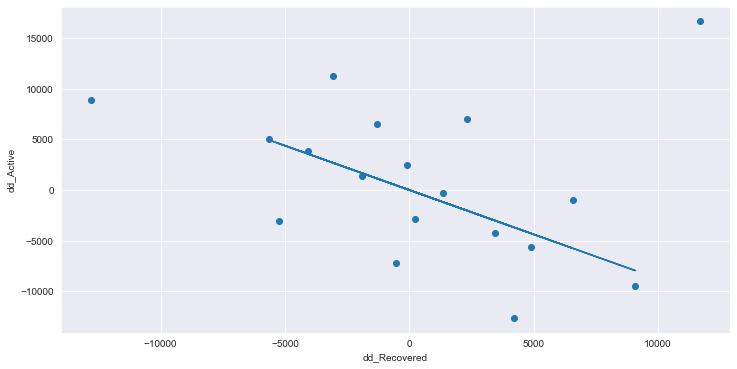

In [14]:
d_yr, d_ya = np.diff(yr), np.diff(ya)  # first difference
dd_yr, dd_ya = np.diff(d_yr), np.diff(d_ya)  # second difference
plt.scatter(dd_yr, dd_ya)

# Outlier detection
data = np.array([dd_yr, dd_ya]).T
outlier_detector = skc.EllipticEnvelope().fit(data)
in_data = outlier_detector.predict(data) == 1
data = data[in_data]  # outlier removed

dd_x, dd_y = data[:,[0]], data[:,[1]]
model2 = sklm.LinearRegression()
model2.fit(dd_x, dd_y)

plt.plot(dd_x, model2.predict(dd_x))
plt.xlabel('dd_Recovered')
plt.ylabel('dd_Active')
print('R2 score:', model2.score(dd_x, dd_y))
print('RMSE error:', np.sqrt(((model2.predict(dd_x)-dd_y)**2).mean()))

In [15]:
d_pyr = pyr - yr[-1]  # new first difference
dd_pyr = d_pyr - d_yr[-1]  # new second difference
dd_pya = np.round(model2.predict([[dd_pyr]])).astype(int)[0][0]  # predicted second difference
d_pya = dd_pya + d_ya[-1]  # predicted first difference
pya = d_pya + ya[-1]  # predicted active cases

In [16]:
print('Predicted active cases:', pya)
print('Predicted recovery:', pyr)
print('Predicted deaths:', pyd)
print('Predicted confirmations:', pya + pyr + pyd)

Predicted active cases: 802286
Predicted recovery: 3154500
Predicted deaths: 69922
Predicted confirmations: 4026708


## A single function

In [17]:
def predict(df, px=None, verbose=True, remove_outliers=False):
    x = np.array([df.index.dayofyear]).T
    x -= x.min()
    yd, yr, ya = np.array(df['Deaths']), np.array(df['Recovered']), np.array(df['Active'])
    lyd, lyr, lya = np.log((yd, yr, ya))  # transform coordinate

    y = np.array([lyd, lyr]).T
    model = sklm.LinearRegression()
    model.fit(x, y)
    if verbose:
        print('Model for deaths and recovery')
        print('    R2 score:', model.score(x, y))
        print('    RMSE error:', np.sqrt(((model.predict(x)-y)**2).mean()))

    if px is None:
        px = x[-1, 0] + 1
    pyd, pyr = np.round(np.exp(model.predict([[px]]))).astype(int)[0]
    
    d_yr, d_ya = np.diff(yr), np.diff(ya)  # first difference
    dd_yr, dd_ya = np.diff(d_yr), np.diff(d_ya)  # second difference

    data = np.array([dd_yr, dd_ya]).T
    if remove_outliers:  # Outlier detection
        outlier_detector = skc.EllipticEnvelope().fit(data)
        in_data = outlier_detector.predict(data) == 1
        data_ = data[in_data]  # outlier removed
    else:
        data_ = data

    dd_x, dd_y = data_[:,[0]], data_[:,[1]]
    if verbose:
        plt.scatter(dd_x, dd_y)
        if remove_outliers:
            plt.scatter(data[~in_data][:,[0]], data[~in_data][:,[1]], c='r', label='Outlier')
        plt.legend()
        plt.xlabel('dd_Recovered')
        plt.ylabel('dd_Active')
        plt.title('Plot of second difference with outliers')
    model2 = sklm.LinearRegression()
    model2.fit(dd_x, dd_y)

    if verbose:
        plt.plot(dd_x, model2.predict(dd_x))
        print('\nModel for second difference of recovery and active cases')
        print('    R2 score:', model2.score(dd_x, dd_y))
        print('    RMSE error:', np.sqrt(((model2.predict(dd_x)-dd_y)**2).mean()))
    
    d_pyr = pyr - yr[-1]  # new first difference
    dd_pyr = d_pyr - d_yr[-1]  # new second difference
    dd_pya = np.round(model2.predict([[dd_pyr]])).astype(int)[0][0]  # predicted second difference
    d_pya = dd_pya + d_ya[-1]  # predicted first difference
    pya = d_pya + ya[-1]  # predicted active cases
    
    return pd.Series(data=[pya, pyr, pyd, pya+pyr+pyd],
                    index=['Active', 'Recovered', 'Deaths', 'Confirmed'],
                    name=df.iloc[-1].name + dt.timedelta(days=1))

No handles with labels found to put in legend.


Model for deaths and recovery
    R2 score: 0.9977570473195121
    RMSE error: 0.005878380382358461

Model for second difference of recovery and active cases
    R2 score: 0.05215384513438315
    RMSE error: 7181.834972709072

Predicted:
Active        832630
Recovered    3154500
Deaths         69922
Confirmed    4057052
Name: 2020-09-04 00:00:00+00:00, dtype: int64


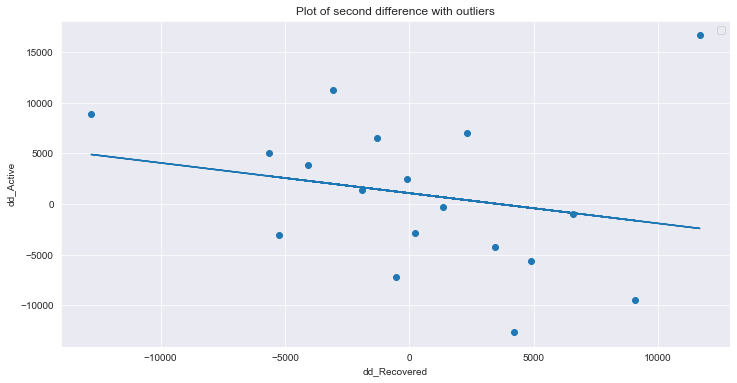

In [18]:
window_size = 20
last_df = df[-window_size:]
predicted = predict(last_df)
print('\nPredicted:')
print(predicted)
last_df = last_df.append(predicted)

## Checking some accuracy

In [19]:
window_size, n = 20, 0
summ = np.zeros(4)
rmse_sum = np.zeros(4)
for i in range(-100, -window_size-1):
    df_data = df.iloc[i:i+window_size]
    df_real = df.iloc[i+window_size]
    df_pred = predict(df_data, verbose=False)

#     print()
#     lines = [str(df_real).splitlines(), str(df_pred).splitlines()]
#     for l in zip(*lines):
#         a, b = l
#         print(a.ljust(50), b)
#     print()

    summ += np.abs(df_real - df_pred) / df_real
    rmse_sum += np.abs(df_real - df_pred)**2
    n += 1

print(f'Checking for {n} instances and with {window_size} cases per window...')
print('Average percentage error per column')
avg = summ / n
print(f'    Active: {avg[0]:.2%}')
print(f'    Recovered: {avg[1]:.2%}')
print(f'    Deaths: {avg[2]:.2%}')
print(f'    Confirmed: {avg[3]:.2%}')

print('\nRMSE')
rmse = np.sqrt(rmse_sum/n)
print(f'    Active: {rmse[0]}')
print(f'    Recovered: {rmse[1]}')
print(f'    Deaths: {rmse[2]}')
print(f'    Confirmed: {rmse[3]}')

Checking for 79 instances and with 20 cases per window...
Average percentage error per column
    Active: 2.46%
    Recovered: 1.44%
    Deaths: 2.14%
    Confirmed: 0.36%

RMSE
    Active: 16748.04449835823
    Recovered: 27040.477218234766
    Deaths: 631.8916547092067
    Confirmed: 16206.774607856845


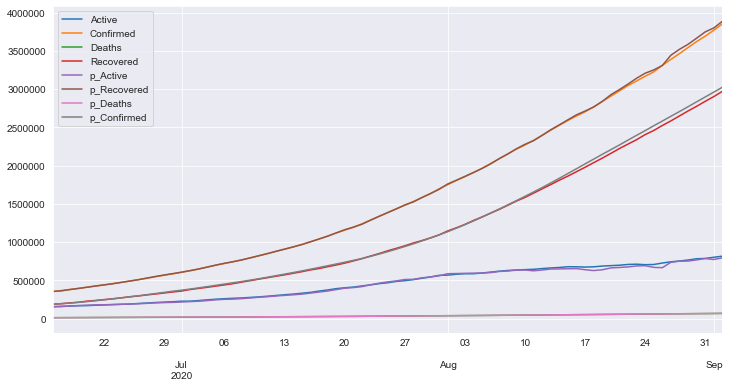

In [27]:
window_size, n = 20, 0
summ = np.zeros(4)
rmse_sum = np.zeros(4)
pdr, pdp = pd.DataFrame(), pd.DataFrame()
for i in range(-100, -window_size-1):
    df_data = df.iloc[i:i+window_size]
    df_real = df.iloc[i+window_size]
    df_pred = predict(df_data, verbose=False)

    pdr = pdr.append(df_real)
    pdp = pdp.append(df_pred)

pdp.columns = map(lambda x: f'p_{x}', cols)
res = pd.concat([pdr,pdp], axis=1)

if interactive:
    res.iplot(title='Real Vs Prediction', xTitle='Date', yTitle='Number of Cases')
else:
    res.plot()